In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1
from scipy.stats import norm


In [4]:
def uniswapV3_TV(S, priceUpper, priceLower):
    K = np.sqrt(priceUpper*priceLower)
    r = np.sqrt(priceUpper/priceLower)
    
    return (2*np.sqrt(K*r*S) - K - S) / (r - 1)
    

In [5]:
params = {'priceUpper': 2000, 'priceLower': 900, 'current_price': 1000, 'x0': 500, 'T': 0.1, 'r':0.1, 'sigma':0.7}


In [6]:
priceUpper = params['priceUpper']
priceLower = params['priceLower']
current_price = params['current_price']

initial_TV = params['x0'] * 2 # => we assume lowerPrice = current_price*0.5, upperPrice = current_price*2
y0 = params['x0']/current_price
T = params['T']
r = params['r']
sigma = params['sigma']


In [7]:
initial_TV

1000

In [8]:
# amount of option contracts to protect initial_TV

amount = uniswapV3_TV(priceLower, priceUpper, priceLower) / priceLower



In [9]:
mid_prices = [price for price in range(priceLower, priceUpper, 1)]
low_prices = list(range(0, priceLower+10, 10))
high_prices = list(range(priceUpper, 3000, 10))
hodl_eth = [x for x in low_prices]
hodl_usdc = [np.sqrt(priceUpper*priceLower)] * len(high_prices)
TVs = [uniswapV3_TV(price, priceUpper, priceLower) for price in mid_prices]

In [10]:
N = norm.cdf

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [11]:
all_prices.index(current_price)

NameError: name 'all_prices' is not defined

In [12]:
hodl_usdc

[1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,
 1341.640786499874,


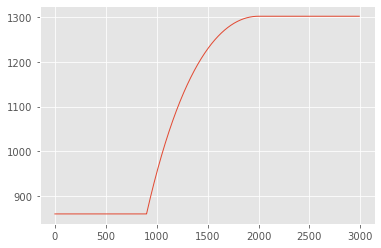

In [13]:
all_prices = low_prices + mid_prices + high_prices
TV1 = [priceLower - BS_PUT(current_price, priceLower, T, r, sigma) for price in low_prices]
TV2 = list(map(lambda x: x - BS_PUT(current_price, priceLower, T, r, sigma), hodl_usdc))
_TV = TV1 + list(map(lambda x: x - BS_PUT(current_price, priceLower, T, r, sigma), TVs)) + TV2
plt.plot(all_prices, _TV)

In [14]:
BS_PUT(current_price, priceLower, T, r, sigma)

39.85708089014361

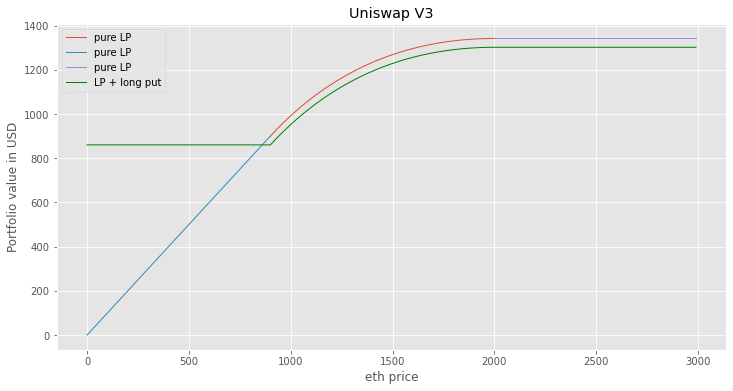

In [15]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
ax.plot(mid_prices, TVs)
ax.plot(low_prices, hodl_eth)
ax.plot(high_prices, hodl_usdc)
ax.plot(all_prices, _TV, 'g')
# ax.set_ylim(ymax=1400)
ax.set_title('Uniswap V3')
ax.set_xlabel('eth price')
ax.set_ylabel('Portfolio value in USD')
ax.legend(['pure LP', 'pure LP', 'pure LP', 'LP + long put'])